In [1]:
%matplotlib inline
import sys
sys.path.insert(0,'../src')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from sklearn import mixture
import SimpleITK as sitk
from imagedisplay import myshow

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Expectation-Maximization algorithm based segmentation 
# Distribution of the intensity values are modelled as a mixture of Gaussians (GMM). 
# The function "my_em_segmentation" find the optimal GMM model parameters using EM algorithm. 

def my_em_segmentation(imagefilename, plot_dist=False):

    # Read the brain slice image
    max_int_val = 512;
    image = sitk.ReadImage(imagefilename)
    image = sitk.Cast(image, sitk.sitkFloat32 )
    image = sitk.RescaleIntensity(image,0.0,max_int_val)
    image_data = sitk.GetArrayFromImage(image);
    image_data_1D = image_data.reshape((image_data.size,1))

    # Compute the parameters for the Gaussian Mixture model
    np.random.seed(1)
    g = mixture.GMM(n_components=4, covariance_type='diag', tol=1e-6, n_iter=100, 
                    n_init=1, params='wmc', init_params='wmc')

    # Estimate model parameters with the expectation-maximization algorithm.
    g.fit(image_data_1D) 

    # pdf of each gaussian model
    def plot_pdf_models(x, g):
        we = g.weights_
        mu = g.means_
        si = np.sqrt(g.covars_)
        for ind in range(0,we.shape[0]): 
            plt.plot(x,we[ind]*mlab.normpdf(x, mu[ind], si[ind]),linewidth=4)

    if plot_dist:         
        # Class probability distribution function
        x = np.linspace(0,max_int_val,500)
        plt.figure(figsize=(16, 5), dpi=100)
        plot_pdf_models(x,g)
        plt.hist(image_data.flatten(), bins=max_int_val/6, range=(0, max_int_val), normed=True)
        plt.title('Class specific probability distribution functions',fontsize=20)
        plt.show()

        # Plot the histogram and the approximated mixture model
        plt.figure(figsize=(16, 5), dpi=100)
        plt.hist( image_data.flatten(), bins=max_int_val/6, range=(0, max_int_val),
                  normed=True, color='m', label='Intensity histogram')
        plt.plot(x,np.exp(g.score(x.reshape(-1, 1))), linewidth=4, color='k', label='Gaussian Mixture Model')
        plt.title('Intensity histogram & Gaussian mixture model',fontsize=20)
        plt.legend(loc=1, shadow=True, fontsize=20)
        plt.show()

        # Single components (class posterioe)
        plt.figure(figsize=(16, 3), dpi=100)
        plt.plot(x,g.predict_proba(x.reshape(-1, 1)), linewidth=4)
        plt.title('Class posterior probability under each Gaussian in the model',fontsize=20)
        plt.show()

    # Compute label image
    label_data = g.predict(image_data_1D) 
    label_data = label_data.reshape(image_data.shape)
    label_image = sitk.GetImageFromArray(label_data)
    sitk.Image.CopyInformation(label_image,image) 

    myshow(image[:,:, image.GetSize()[2]/2], title='2D Input image', dpi=42)
    myshow(sitk.LabelToRGB(label_image[:,:, image.GetSize()[2]/2]), title='EM-GMM segmentation', dpi=42)
    
    return label_image

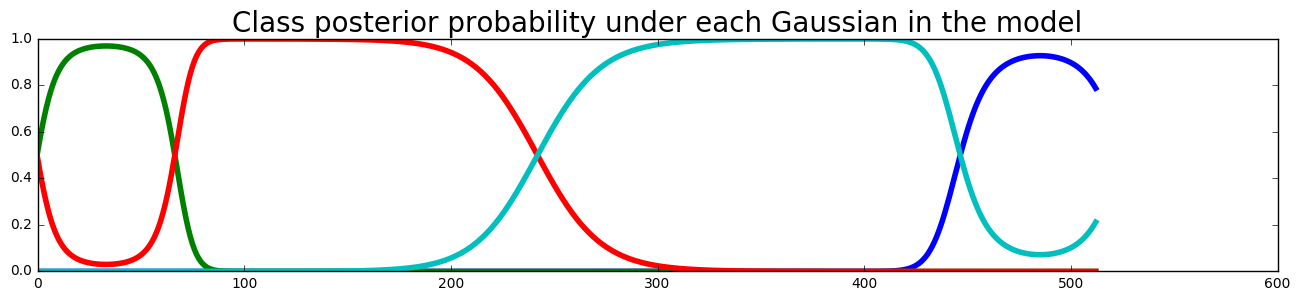

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f5e9e15ca20> >

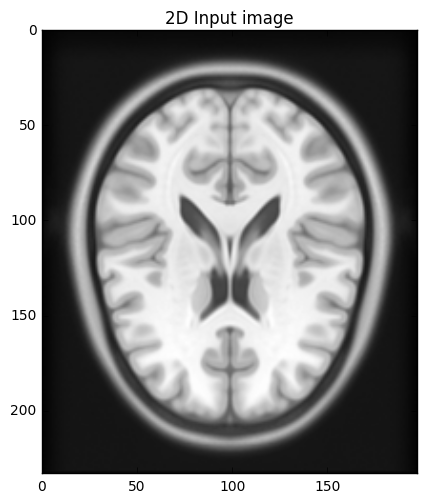

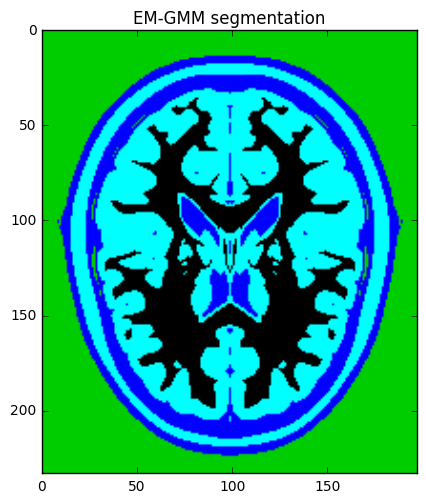

In [3]:
# EM algorithm is applied on an atlas brain image (a 2D-slice)
imagefilename2 = "../data/atlas_slicez90.nii.gz"
my_em_segmentation(imagefilename2, plot_dist=True)

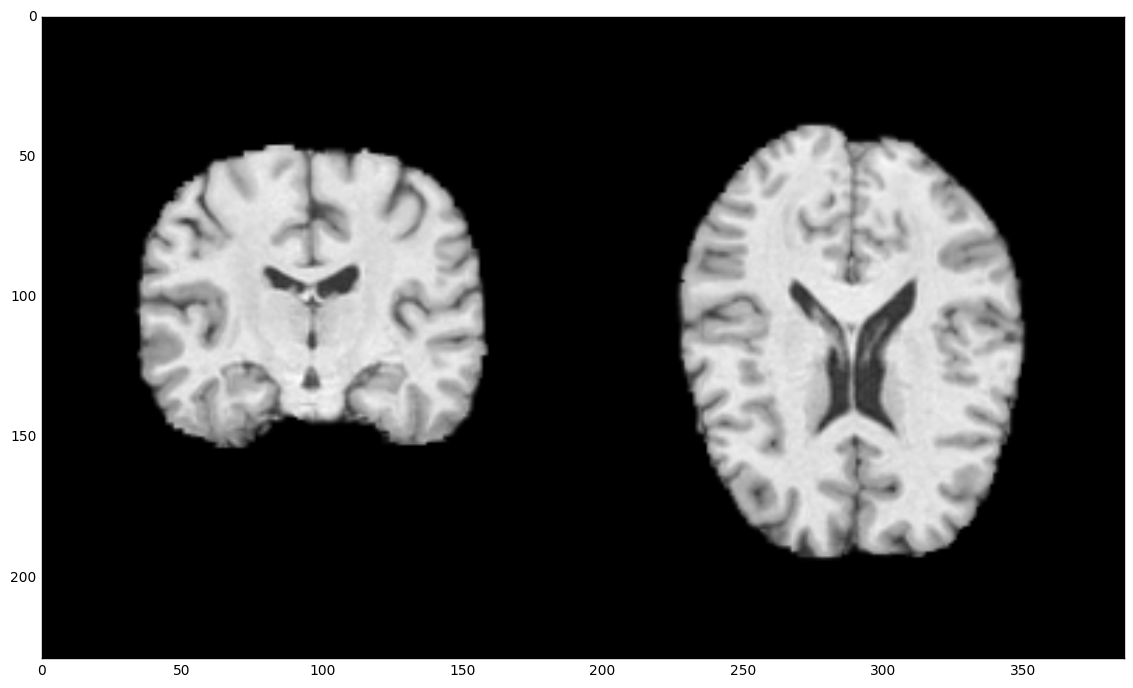

In [4]:
# The same method is applied on 3D MR brain image. 
# The segmentation results are noisy due to lack of spatial consistency. 

# Read the brain image
imagefilename = "../data/test.nii.gz" 
image = sitk.ReadImage(imagefilename)
image = sitk.Cast(image, sitk.sitkFloat32 )
image_data = sitk.GetArrayFromImage(image)
input_shape = image_data.shape
image_data = image_data.flatten()

# Compute the parameters for the Gaussian Mixture model
# For improved performance please increase the number of iterations (longer computation time)
np.random.seed(1)
g = mixture.GMM(n_components=4, covariance_type='diag', tol=1e-6, n_iter=50, 
                n_init=1, params='wmc', init_params='wmc')

# Estimate model parameters with the expectation-maximization algorithm.
g.fit(image_data.reshape(-1,1)) 

# Predict the labels 
segm_data = np.zeros(input_shape).flatten()
segm_data = g.predict(image_data.reshape(-1,1))
segm_data = segm_data.reshape(input_shape)
segm_img  = sitk.GetImageFromArray(segm_data)
sitk.Image.CopyInformation(segm_img,image)

# display the labels and the original image
imageSize = image.GetSize()
segm_img = sitk.Cast(segm_img, sitk.sitkUInt16)
slices =[image[:,imageSize[1]/2,::-1], image[:,:,94]]
myshow(sitk.Tile(slices, [2,1]), dpi=20)
slices =[segm_img[:,imageSize[1]/2,::-1], segm_img[:,:,94]]
myshow(sitk.LabelToRGB(sitk.Tile(slices, [2,1])), dpi=20)

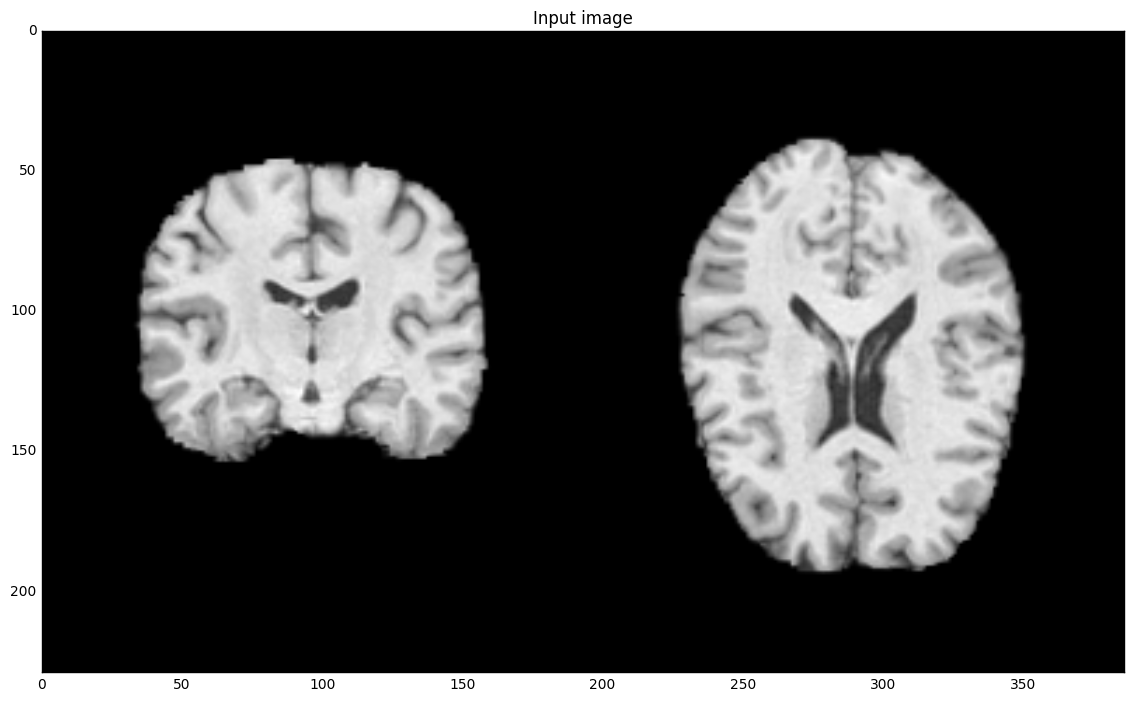

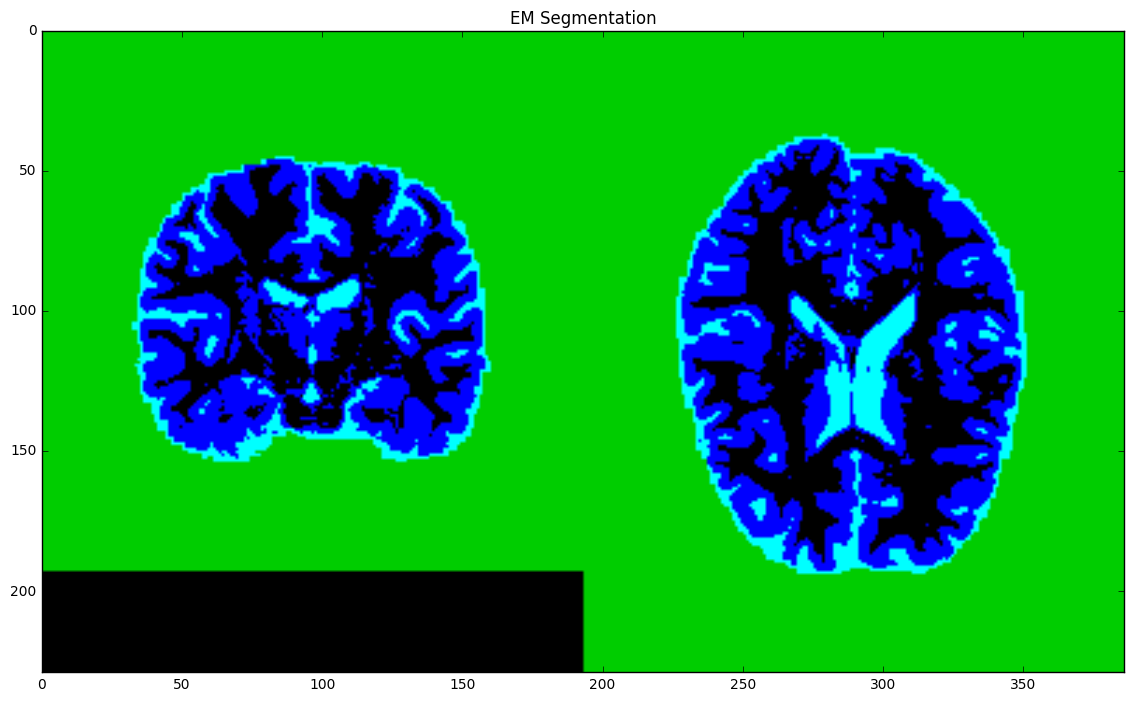

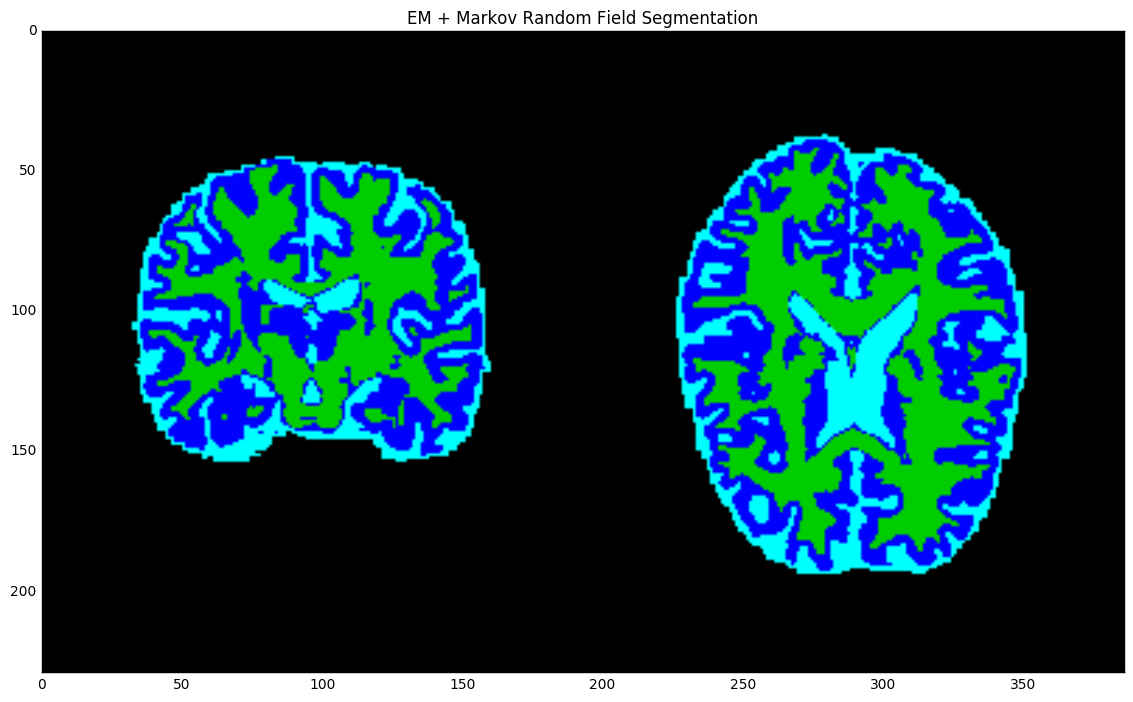

In [5]:
# This time, the same image is segmented using a different method:
# EM algorithm using Markov random fields (MRF). 
# MRF ensures spatial consistency of the segmentation labels

# sudo pip install nipy
from nipy import load_image, save_image
from nipy.core.image.image_spaces import (make_xyz_image,xyz_affine)
from nipy.algorithms.segmentation import BrainT1Segmentation

# Read the input image
imagefilename1 = "../data/test.nii.gz" 

# Input image
img      = load_image(imagefilename1)
mask     = img.get_data() > 0

# Perform tissue classification
S = BrainT1Segmentation(img.get_data(),
                        mask=mask,       # the algorithm ignores the background pixels for faster comp.
                        model='5k',
                        niters=int(50),  # number of iterations
                        beta=float(0.4), # Markov regularization parameter
                        ngb_size=int(6)) # neighborhood size of MRF
labelimg    = make_xyz_image(S.label, xyz_affine(img), 'scanner')
labelarray = labelimg.get_data()

# Swap the dimensions and label Ids for better visualization
labelarray      = np.swapaxes(labelarray,0,2)
labelarray[labelarray==3] = 4
labelarray[labelarray==2] = 5
labelarray[labelarray==1] = 6
labelarray[labelarray==0] = 3
labelarray                = labelarray-3

# Create a SimpleITK image using the numpy array
emrf_segm_img = sitk.GetImageFromArray(labelarray)
emrf_segm_img.CopyInformation(image) 

# Show the label image
imageSize      = image.GetSize()
emrf_segm_img  = sitk.Cast(emrf_segm_img, sitk.sitkUInt16)
slices =[image[:,imageSize[1]/2,::-1], image[:,:,94]]
myshow(sitk.Tile(slices, [2,1]), dpi=20, title='Input image')
slices =[segm_img[:,imageSize[1]/2,::-1], segm_img[:,:,94]]
myshow(sitk.LabelToRGB(sitk.Tile(slices, [2,1])), dpi=20, title='EM Segmentation')  
slices =[emrf_segm_img[:,imageSize[1]/2,::-1], emrf_segm_img[:,:,94]]
myshow(sitk.LabelToRGB(sitk.Tile(slices, [2,1])), dpi=20, title='EM + Markov Random Field Segmentation')   